In [1]:
import ecg_plot
from evaluate_model import *
from my_helper_code import *
from helper_code import *
from scipy.misc import electrocardiogram
from BaselineRemoval import BaselineRemoval

In [ ]:
from helper_code import *
train_data_directory = 'test_data'
train_header_files, train_recording_files = find_challenge_files(train_data_directory)
train_header_files

In [3]:
ecg = load_recording(train_recording_files[1])[1]
ecg.shape, ecg.mean(), ecg.std()

((7870,), 0.0012706480304955528, 117.20867910850305)

In [8]:
import heartpy as hp
working_data, measures = hp.process(ecg, 500.0)


In [9]:
print(measures['bpm']) #returns BPM value
print(measures['rmssd']) # returns RMSSD HRV measure

59.77418640690723
21.85177338341216


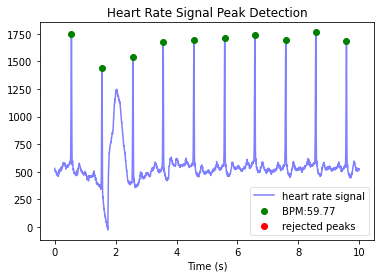

In [10]:
hp.plotter(working_data, measures)

In [17]:
ecg = load_recording(train_recording_files[150])[1]

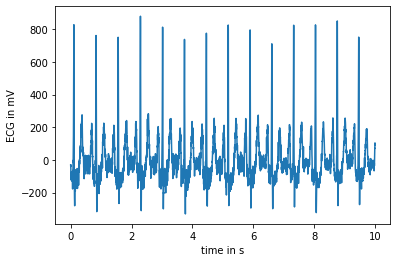

In [18]:
import matplotlib.pyplot as plt
fs = 500
time = np.arange(ecg.size) / fs
plt.plot(time, ecg)
plt.xlabel("time in s")
plt.ylabel("ECG in mV")

plt.show()



In [19]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als(y, lam, p, niter=10):
  L = len(y)
  D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z

In [14]:
r = baseline_als(ecg,1,.1)

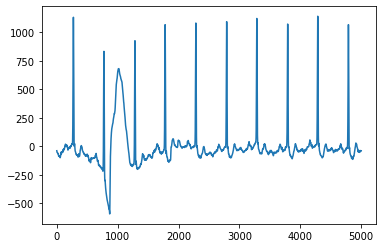

In [15]:
plt.plot(r)

In [16]:
import numpy as np
import pywt


def calc_baseline(signal):
    """
    Calculate the baseline of signal.

    Args:
        signal (numpy 1d array): signal whose baseline should be calculated


    Returns:
        baseline (numpy 1d array with same size as signal): baseline of the signal
    """
    ssds = np.zeros((3))

    cur_lp = np.copy(signal)
    iterations = 0
    while True:
        # Decompose 1 level
        lp, hp = pywt.dwt(cur_lp, "db4")

        # Shift and calculate the energy of detail/high pass coefficient
        ssds = np.concatenate(([np.sum(hp ** 2)], ssds[:-1]))

        # Check if we are in the local minimum of energy function of high-pass signal
        if ssds[2] > ssds[1] and ssds[1] < ssds[0]:
            break

        cur_lp = lp[:]
        iterations += 1

    # Reconstruct the baseline from this level low pass signal up to the original length
    baseline = cur_lp[:]
    for _ in range(iterations):
        baseline = pywt.idwt(baseline, np.zeros((len(baseline))), "db4")

    return baseline[: len(signal)]

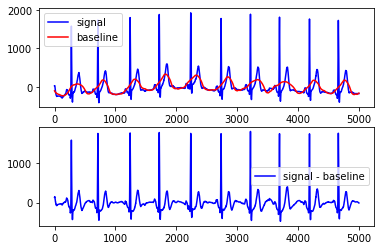

In [31]:
import matplotlib.pyplot as plt
import numpy as np


a =890
ecg = load_recording(train_recording_files[a])[1]
baseline = calc_baseline(ecg)

# Remove baseline from orgianl signal
ecg_out = ecg - baseline

plt.subplot(2, 1, 1)
plt.plot(ecg, "b-", label="signal")
plt.plot(baseline, "r-", label="baseline")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(ecg_out, "b-", label="signal - baseline")
plt.legend()
plt.savefig(f'BaseLine Correction{a}.png')
plt.show()


In [68]:
ecg = load_recording(train_recording_files[20])[4,:8192]

In [4]:
from scipy import signal
from scipy.signal import butter, iirnotch, lfilter
import numpy as np
import matplotlib.pyplot as plt
## A high pass filter allows frequencies higher than a cut-off value
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False, output='ba')
    return b, a






def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False, output='ba')
    return b, a


def final_filter(data, fs, order=5):
#     b, a = butter_highpass(cutoff_high, fs, order=order)
#     x = lfilter(b, a, data)
    b, a = butter_lowpass(cutoff_low, fs, order=order)
    x = lfilter(b, a, data)
    return x

fs = 500
## Order of five works well with ECG signals
cutoff_high = .5
cutoff_low =100
powerline = 500
# order = 5
# plt.figure(1)
# ax1 = plt.subplot(211)
# plt.plot(ecg)
# ax1.set_title("Raw ECG signal")

# filter_signal = final_filter(ecg, fs, order)
# ax2 = plt.subplot(212)
# plt.plot(filter_signal)
# ax2.set_title("Clean ECG signal")
# plt.show()

In [41]:
from scipy.io import loadmat
import tqdm
import os
from scipy.io import savemat
path = 'Baseline correction test'
from helper_code import *
train_data_directory = 'test_data'
train_header_files, train_recording_files = find_challenge_files(train_data_directory)
import numpy as np
import pywt


def calc_baseline(signal):
    ssds = np.zeros((3))

    cur_lp = np.copy(signal)
    iterations = 0
    while True:
        # Decompose 1 level
        lp, hp = pywt.dwt(cur_lp, "db4")

        # Shift and calculate the energy of detail/high pass coefficient
        ssds = np.concatenate(([np.sum(hp ** 2)], ssds[:-1]))

        # Check if we are in the local minimum of energy function of high-pass signal
        if ssds[2] > ssds[1] and ssds[1] < ssds[0]:
            break

        cur_lp = lp[:]
        iterations += 1
        if iterations == 20:
            break
        
    # Reconstruct the baseline from this level low pass signal up to the original length
    baseline = cur_lp[:]
    for _ in range(iterations):
        baseline = pywt.idwt(baseline, np.zeros((len(baseline))), "db4")

    return baseline[: len(signal)]

               


In [42]:
for i in tqdm.tqdm(train_recording_files) :
    x =  loadmat (i)
    #print(i)
    for j in range(x['val'].shape[0]):
        header = load_header(i.replace('mat','hea'))
        orig_sr = int(header.split(' ')[2])
        ecg = x['val'][j]
        ecg = final_filter(ecg,orig_sr,5)
        baseline = calc_baseline(ecg)
        ecg_out = ecg - baseline
        x['val'][j] = ecg_out
    savemat(os.path.join(path,i.split('\\')[-1]), x) 

100%|██████████████████████████████████████████████████████████████████████████████| 4413/4413 [03:14<00:00, 22.73it/s]


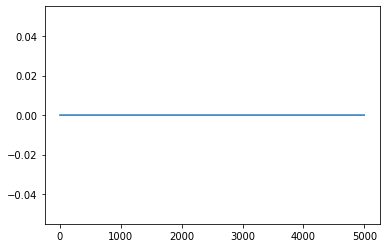

In [35]:
x =  loadmat ('training_data\A0718.mat')
#plt.plot(x['val'][0])
baseline = calc_baseline(x['val'][10])
ecg_out = x['val'][10] - baseline
plt.plot(x['val'][11])

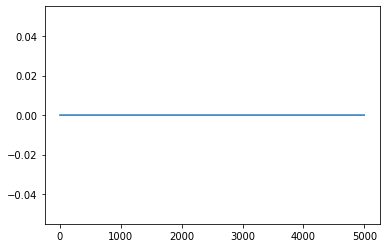

In [37]:
x =  loadmat ('training_data\A0718.mat')
plt.plot(x['val'][11])

In [3]:
import psutil # Can be found at https://pypi.org/project/psutil/

psutil.virtual_memory()

svmem(total=17126621184, available=11994206208, percent=30.0, used=5132414976, free=11994206208)

In [117]:
import shutil
import tqdm
for i in tqdm.tqdm(train_recording_files):
    shutil.copyfile(i.replace('mat','hea'),i.replace('test_data',train_data_directory).replace('mat','hea'))

100%|█████████████████████████████████████████████████████████████████████████████| 4413/4413 [00:24<00:00, 183.07it/s]


In [116]:
train_recording_files[0].replace('test_data',train_data_directory).replace('mat','hea')

'Baseline correction test\\A0011.hea'

In [ ]:
train_recording_files.replace